In [167]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib

auto_mpg = fetch_ucirepo(id=9)
X = auto_mpg.data.features.copy()
y = auto_mpg.data.targets.copy()

df = pd.concat([X, y], axis=1)

display(df.head(5))
display(df.columns)
display(df.info())
display(df.isnull().sum())
display(df.describe())

# Gerekli veri seti indirildikten sonra, veri setinin ilk 5 satırını görüntülenmiştir ve veri setinde eksik değerler, sütun isimleri, ortalama, standart sapma gibi istatistiksel bilgiler incelenmiştir.

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
0,307.0,8,130.0,3504,12.0,70,1,18.0
1,350.0,8,165.0,3693,11.5,70,1,15.0
2,318.0,8,150.0,3436,11.0,70,1,18.0
3,304.0,8,150.0,3433,12.0,70,1,16.0
4,302.0,8,140.0,3449,10.5,70,1,17.0


Index(['displacement', 'cylinders', 'horsepower', 'weight', 'acceleration',
       'model_year', 'origin', 'mpg'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   displacement  398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   horsepower    392 non-null    float64
 3   weight        398 non-null    int64  
 4   acceleration  398 non-null    float64
 5   model_year    398 non-null    int64  
 6   origin        398 non-null    int64  
 7   mpg           398 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 25.0 KB


None

displacement    0
cylinders       0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
mpg             0
dtype: int64

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
count,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,193.425879,5.454774,104.469388,2970.424623,15.568090,76.010050,1.572864,23.514573
std,104.269838,1.701004,38.491160,846.841774,2.757689,3.697627,0.802055,7.815984
min,68.000000,3.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,9.000000
25%,104.250000,4.000000,75.000000,2223.750000,13.825000,73.000000,1.000000,17.500000
50%,148.500000,4.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,23.000000
75%,262.000000,8.000000,126.000000,3608.000000,17.175000,79.000000,2.000000,29.000000
max,455.000000,8.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,46.600000


In [168]:
X["horsepower"] = X["horsepower"].fillna(X["horsepower"].median())
display(X["horsepower"].describe())

# horsepower isimli sütunda eksik değerler olduğu için, bu sütundaki eksik değerler medyan ile doldurulmuştur. Daha sonra, horsepower isimli sütunun istatistiksel bilgileri görüntülenmiştir.

count    398.000000
mean     104.304020
std       38.222625
min       46.000000
25%       76.000000
50%       93.500000
75%      125.000000
max      230.000000
Name: horsepower, dtype: float64

In [169]:
one_hot = pd.get_dummies(X["origin"], prefix="origin")
X = pd.concat([X, one_hot], axis=1)
X = X.drop(columns=["origin"])

# "origin" isimli kategorik değişkenin one-hot encoding yöntemi ile sayısal verilere dönüştürülmesi sağlanmıştır. Daha sonra, orijinal "origin" isimli sütun, veri setinden çıkarılmıştır.

In [170]:
X["log_weight"] = np.log(X["weight"])
X["log_displacement"] = np.log(X["displacement"])

X["weight_squared"] = X["weight"] ** 2
X["weight_model_year"] = X["weight"] * X["model_year"]
                                                     
X.drop(["weight", "horsepower", "cylinders"], axis=1, inplace=True)

# Grafikte sağa çarpıklığı (right skewed) düzeltmek amacıyla weight sütununa logaritmik dönüşüm yapılmıştır.
# Benzer şekilde displacement sütununa da logaritmik dönüşüm yapılmıştır.
# weight sütununun doğrusal olmayan ilişkisinin de görülmesi amacıyla weight sütununun karesi alınmıştır.
# weight sütunu ile model_year sütununun arasındaki ilişkinin yakalanması amacıyla çarpılıp yeni sütun oluşturulmuştur.
# Son olarak, weight, horsepower ve cylinders sütunları veri setinden çıkarılmıştır.

# Ayrıca weight sütununun küpünü almayı, displacement sütununun karesini almak ve çarpma bölme işlemleriyle yeni sütunlar oluşturmak gibi şeyler denemiş olup, R² değerini azalttığından dolayı kullanmadım.

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

display(X.head(5))
display(X.describe())

# Veri seti %80 eğitim ve %20 test olarak ikiye ayrılmıştır. Daha sonra, MinMaxScaler ile veriler ölçeklendirilmiştir.

,displacement,acceleration,model_year,origin_1,origin_2,origin_3,log_weight,log_displacement,weight_squared,weight_model_year
0,307.0,12.0,70,True,False,False,8.161660,5.726848,12278016,245280
1,350.0,11.5,70,True,False,False,8.214194,5.857933,13638249,258510
2,318.0,11.0,70,True,False,False,8.142063,5.762051,11806096,240520
3,304.0,12.0,70,True,False,False,8.141190,5.717028,11785489,240310
4,302.0,10.5,70,True,False,False,8.145840,5.710427,11895601,241430


,displacement,acceleration,model_year,log_weight,log_displacement,weight_squared,weight_model_year
count,398.000000,398.000000,398.000000,398.000000,398.000000,3.980000e+02,398.000000
mean,193.425879,15.568090,76.010050,7.956890,5.123174,9.538762e+06,224824.590452
std,104.269838,2.757689,3.697627,0.280665,0.531279,5.453778e+06,60902.479826
min,68.000000,8.000000,70.000000,7.385851,4.219508,2.601769e+06,114523.000000
25%,104.250000,13.825000,73.000000,7.706950,4.646783,4.945066e+06,169000.000000
50%,148.500000,15.500000,76.000000,7.938623,5.000443,7.859624e+06,215117.500000
75%,262.000000,17.175000,79.000000,8.190909,5.568345,1.301767e+07,270900.000000
max,455.000000,24.800000,82.000000,8.544808,6.120297,2.641960e+07,364940.000000


In [172]:
model = LinearRegression()

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.4f}")

# Eğitim verileri ile lineer regresyon kullanılarak model eğitilmiş ve test verileri ile tahmin yapılmıştır. Daha sonra, ortalama kare hata (MSE) ve R² değerleri hesaplanmıştır.

MSE: 4.94
R²: 0.9310


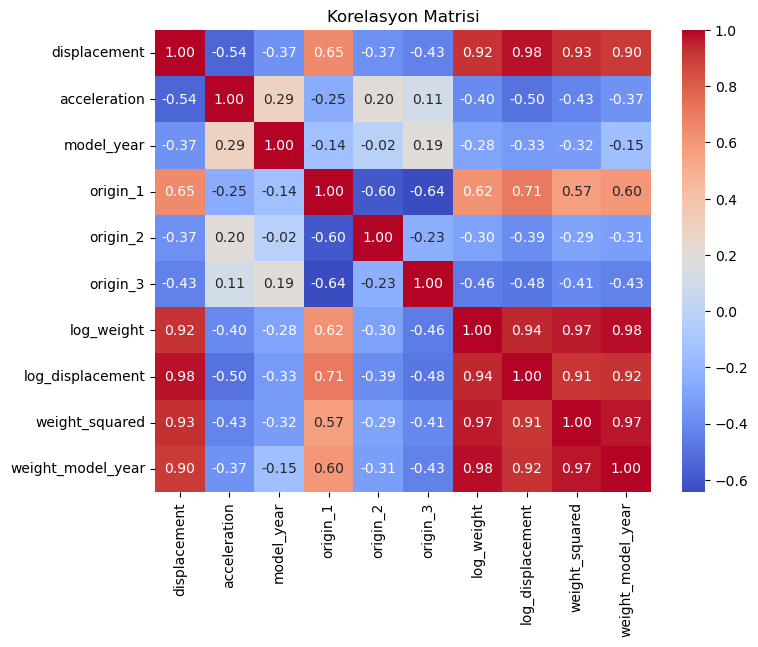

displacement: 285.71
acceleration: 52.77
model_year: 1082.84
log_weight: 6368.48
log_displacement: 6550.16
weight_squared: 332.30
weight_model_year: 822.77


In [173]:
cor = X.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cor, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasyon Matrisi")
plt.show()

X.drop(["origin_1", "origin_2", "origin_3"], axis=1, inplace=True)
for i, col in enumerate(X.columns):
    vif = variance_inflation_factor(X.values, i)
    print(f"{col}: {vif:.2f}")

# Veri setinin korelasyon haritasına bakılıp, vif değerleri yazdırılmıştır. Bu değerlere göre modelin R² değerini arttırmak amacıyla değişiklikler yapılmıştır.
# Korelasyon ve vif değeri yüksek olan sütunlar çıkarılıp denenmiştir ama R² değerini düşürdüğünden dolayı kullanmadım.
# Özellikle log_weight ve log_displacement sütunları arasında vif değeri çok yüksek ama maalesef çıkarıldığı zaman R² ve MSE değerleri olumsuz etkilenmiştir.

In [174]:
joblib.dump(model, "model.joblib")

# Model joblib olarak kaydedilmiştir.

['model.joblib']